In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycaret.time_series import *
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
)
from statsmodels.tsa.deterministic import Fourier

# Load data
df = pd.read_csv("CSV\export-jsps016-1h.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"], format="mixed")
df.set_index("timestamp", inplace=True)

# Keep only the last 1 year of data
one_year_ago = df.index.max() - pd.DateOffset(years=2)
df = df[df.index >= one_year_ago]

# Drop unnecessary columns
df.drop(columns=["timezone", "Unnamed: 0", "pm_2_5_sp","location" ,"pm_10"], inplace=True, errors="ignore")

# Resample to hourly and fill missing values

# Remove outliers using IQR
Q1 = df["pm_2_5"].quantile(0.25)
Q3 = df["pm_2_5"].quantile(0.75)
IQR = Q3 - Q1
df = df[(df["pm_2_5"] >= Q1 - 1.5 * IQR) & (df["pm_2_5"] <= Q3 + 1.5 * IQR)]

Q1t = df["temperature"].quantile(0.25)
Q3t = df["temperature"].quantile(0.75)
IQRt = Q3t - Q1t
df = df[(df["temperature"] >= Q1t - 1.5 * IQRt) & (df["temperature"] <= Q3t + 1.5 * IQRt)]

Q1h = df["humidity"].quantile(0.25)
Q3h = df["humidity"].quantile(0.75)
IQRh = Q3h - Q1h
df = df[(df["humidity"] >= Q1h - 1.5 * IQRh) & (df["humidity"] <= Q3h + 1.5 * IQRh)]
print(df)
df.interpolate(method="linear", inplace=True)

df = df.resample("D").mean().fillna(method="ffill")

# ✅ ปรับขนาดข้อมูลเป็น 4 ช่วงต่อวัน (ทุก 6 ชั่วโมง)
df = df.resample("D").mean()

# ✅ Fourier Terms (Weekly Seasonality) สำหรับ 4 ช่วงต่อวัน
fourier = Fourier(
    period=7, order=2
)  # Weekly seasonality with lower order (4 periods/day × 7 days)
fourier_features = fourier.in_sample(df.index)
df = pd.concat([df, fourier_features], axis=1)
df.dropna(inplace=True)

# ✅ เพิ่ม Lag Features หลายระดับ (Short-Term & Long-Term) สำหรับ 4 ช่วงต่อวัน
for lag in [
    7 +1,
    7 + 3,
    7 + 7,
    7 + 14,
]:  # 1 วัน, 2 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_lag{lag}"] = df["pm_2_5"].shift(lag)
    df[f"humidity_lag{lag}"] = df["humidity"].shift(lag)
    df[f"temperature_lag{lag}"] = df["temperature"].shift(lag)

# ✅ เพิ่ม Rolling Mean และ Rolling Std หลายระดับ
for window in [2, 3, 5,7,14]:  # 1 วัน, 3 วัน, 7 วัน, 14 วัน (ปรับสเกลเป็น 4 ช่วงต่อวัน)
    df[f"pm_2_5_rollmean{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"pm_2_5_rollstd{window}"] = (
        df["pm_2_5"].shift(7).rolling(window=window, min_periods=1).std()
    )
    # df[f"temperature_rollmean{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    # )
    # df[f"temperature_rollstd{window}"] = (
    #     df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    # )
    df[f"humidity_rollmean{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"humidity_rollstd{window}"] = (
        df["humidity"].shift(7).rolling(window=window, min_periods=1).std()
    )
    df[f"temperature_rollmean{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).mean()
    )
    df[f"temperature_rollstd{window}"] = (
        df["temperature"].shift(7).rolling(window=window, min_periods=1).std()
    )

df = df.drop(columns=["temperature","humidity"])
df = df.asfreq("D").fillna(method="bfill")  # เติมข้อมูลก่อนแบ่ง


# แบ่งข้อมูลสำหรับฝึกและทดสอบ (7 วัน = 28 ช่วง)
train = df.iloc[:-7]  # แบ่ง train
test = df.iloc[-7:]  # แบ่ง test

# ✅ เลือกเฉพาะฟีเจอร์ที่สำคัญ
selected_features = ["pm_2_5"] + [col for col in df.columns if col != "pm_2_5"]
train = train[selected_features]
test = test[selected_features]

                      humidity     pm_2_5  temperature
timestamp                                             
2023-02-11 00:00:00  79.232620   0.159664    28.059333
2023-02-11 01:00:00  81.507885   0.400000    27.782083
2023-02-11 02:00:00  80.749541   0.325000    27.890167
2023-02-11 03:00:00  79.931482   0.141667    27.892333
2023-02-11 04:00:00  80.798001   0.084034    27.720000
...                        ...        ...          ...
2025-02-10 20:00:00  78.457797  27.491667    27.528023
2025-02-10 21:00:00  79.928856  27.444444    27.206744
2025-02-10 22:00:00  80.973189  24.525000    27.015940
2025-02-10 23:00:00  82.318932  26.285714    26.773857
2025-02-11 00:00:00  84.591257  29.625000    26.369456

[15887 rows x 3 columns]


In [3]:
train


,pm_2_5,"sin(1,7)","cos(1,7)","sin(2,7)","cos(2,7)",pm_2_5_lag8,humidity_lag8,temperature_lag8,pm_2_5_lag10,humidity_lag10,...,humidity_rollmean7,humidity_rollstd7,temperature_rollmean7,temperature_rollstd7,pm_2_5_rollmean14,pm_2_5_rollstd14,humidity_rollmean14,humidity_rollstd14,temperature_rollmean14,temperature_rollstd14
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-02-11,0.343356,0.000000e+00,1.000000,0.000000e+00,1.000000,0.343356,71.437279,29.218630,0.343356,71.437279,...,71.437279,0.607553,29.218630,0.327657,0.343356,0.161224,71.437279,0.607553,29.218630,0.327657
2023-02-12,0.571362,7.818315e-01,0.623490,9.749279e-01,-0.222521,0.343356,71.437279,29.218630,0.343356,71.437279,...,71.437279,0.607553,29.218630,0.327657,0.343356,0.161224,71.437279,0.607553,29.218630,0.327657
2023-02-13,0.631156,9.749279e-01,-0.222521,-4.338837e-01,-0.900969,0.343356,71.437279,29.218630,0.343356,71.437279,...,71.437279,0.607553,29.218630,0.327657,0.343356,0.161224,71.437279,0.607553,29.218630,0.327657
2023-02-14,0.770396,4.338837e-01,-0.900969,-7.818315e-01,0.623490,0.343356,71.437279,29.218630,0.343356,71.437279,...,71.437279,0.607553,29.218630,0.327657,0.343356,0.161224,71.437279,0.607553,29.218630,0.327657
2023-02-15,0.489403,-4.338837e-01,-0.900969,7.818315e-01,0.623490,0.343356,71.437279,29.218630,0.343356,71.437279,...,71.437279,0.607553,29.218630,0.327657,0.343356,0.161224,71.437279,0.607553,29.218630,0.327657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-31,27.211724,-7.818315e-01,0.623490,-9.749279e-01,-0.222521,35.483214,82.923149,27.559989,21.059506,82.649257,...,85.971114,5.484332,26.954781,0.853281,26.800247,11.896975,86.478186,4.781051,26.620751,0.871124
2025-02-01,34.580033,-6.075486e-14,1.000000,-1.215097e-13,1.000000,13.679726,91.635092,26.650428,34.378857,79.693503,...,84.763972,5.073932,27.376150,0.732360,26.682411,11.906097,86.124746,4.871467,26.783937,0.984862
2025-02-02,35.374209,7.818315e-01,0.623490,9.749279e-01,-0.222521,25.060975,82.680928,28.445240,35.483214,82.923149,...,83.847876,3.917444,27.572494,0.546475,25.574703,11.952944,86.288674,4.820832,26.861855,1.007964


In [4]:
# ✅ เพิ่ม fold เป็น 5 เพื่อให้โมเดล Generalize ขึ้น
experiment = setup(
    data=train,
    target="pm_2_5",
    session_id=123,
    use_gpu=True,
    fh=7,  # Forecast horizon = 7 days (28 periods)
    fold=2,
    seasonal_period="D",
    verbose=True,
)
test.index = test.index.to_period("D")

# ✅ ลองโมเดล ARIMA ก่อน
arima_model = create_model("arima")
arima_model = tune_model(arima_model)
final_arima = finalize_model(arima_model)

# Predict using the finalized model
X_forecast = test.drop(columns=["pm_2_5"])

,Description,Value
0,session_id,123
1,Target,pm_2_5
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(725, 47)"
5,Transformed data shape,"(725, 47)"
6,Transformed train set shape,"(718, 47)"
7,Transformed test set shape,"(7, 47)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: Intel(R) UHD Graphics 630, Vendor: Intel(R) Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no m

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-14,1.6432,1.5228,13.9316,16.9666,1.5843,0.5969,-0.8371
1,2025-01-21,1.2308,1.1193,10.5286,12.5992,0.6256,0.4499,-0.9583
Mean,NaT,1.4370,1.3211,12.2301,14.7829,1.1050,0.5234,-0.8977
SD,NaT,0.2062,0.2018,1.7015,2.1837,0.4793,0.0735,0.0606


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2025-01-14,2.0088,1.9087,17.0310,21.2660,1.9442,0.6589,-1.8862
1,2025-01-21,1.1208,1.0679,9.5882,12.0209,0.3882,0.4617,-0.7827
Mean,NaT,1.5648,1.4883,13.3096,16.6435,1.1662,0.5603,-1.3344
SD,NaT,0.4440,0.4204,3.7214,4.6226,0.7780,0.0986,0.5518


Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.8min finished


MAE: 5.00
MAPE: 29.60%
R2: -1.22
accurent: 70.40


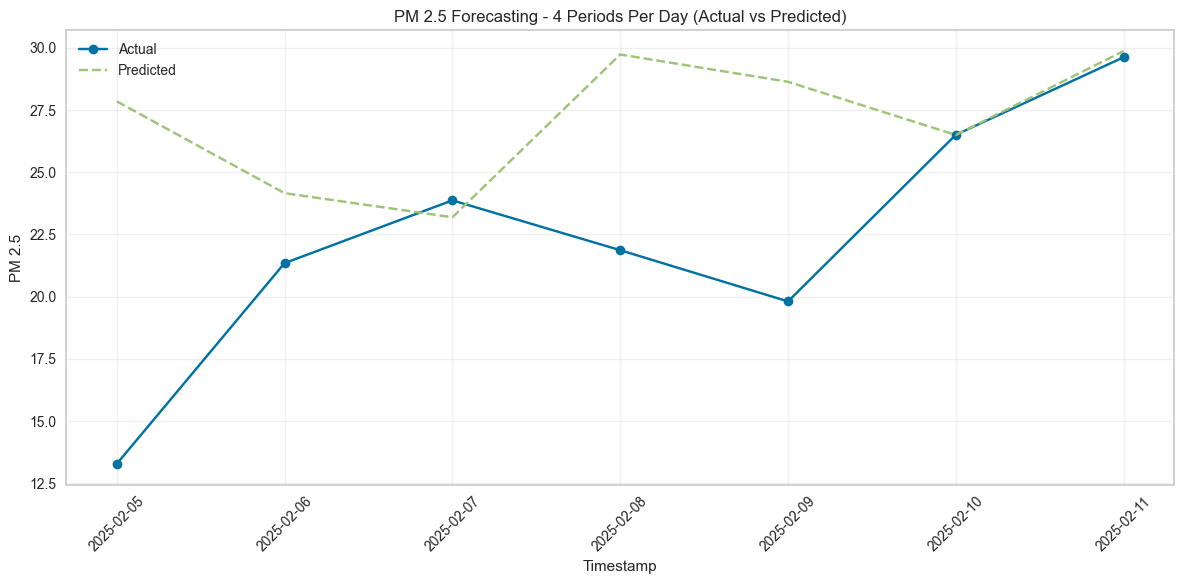

In [5]:
predictions = predict_model(final_arima, X=X_forecast)

# Evaluate Performance
mae = mean_absolute_error(test["pm_2_5"], predictions)
mape = mean_absolute_percentage_error(test["pm_2_5"], predictions) * 100
r2 = r2_score(test["pm_2_5"], predictions)
accurent = 100 - mape

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R2: {r2:.2f}")
print(f"accurent: {accurent:.2f}")

# ✅ แปลง Index ของ test ให้เป็น Timestamp ก่อนทำการ Plot
plt.figure(figsize=(12, 6))
plt.plot(
    test["pm_2_5"].index.to_timestamp(), test["pm_2_5"], label="Actual", marker="o"
)
plt.plot(
    test["pm_2_5"].index.to_timestamp(),
    predictions,
    label="Predicted",
    linestyle="--",
    marker="x",
)
plt.title("PM 2.5 Forecasting - 4 Periods Per Day (Actual vs Predicted)")
plt.xlabel("Timestamp")
plt.ylabel("PM 2.5")
plt.legend()
plt.grid(True, alpha=0.3)

# เพิ่มการแสดงช่วงเวลาให้ชัดเจนขึ้น
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
save_model(final_arima, "jsps016")

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 ARIMA(seasonal_order=(0,
                                                                                                                                                       1,
                                                                                                                                                       0,
                                                                                                                                                       7)))]))]))]))]),
 'jsps01